## `분석주제`

In [1]:
# submission 결과로 최적화한 Feature(20221110_0005)

### Import

In [18]:
import numpy as np
import pandas as pd
# preprocess
from haversine import haversine
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler, Normalizer, MinMaxScaler, PowerTransformer
from sklearn.metrics import mean_absolute_error
# modeling
from sklearn.model_selection import train_test_split
from lightgbm import LGBMRegressor
# from catboost import CatBoostRegressor
# visualize
import matplotlib.pyplot as plt
import seaborn as sns
plt.rc('font', family='Malgun Gothic')
plt.rc('axes', unicode_minus=False)
# ignore warnings
import warnings ; warnings.filterwarnings('ignore')

### Read Data

In [19]:
train = pd.read_csv('/Users/hyunji/1. DaconJeju/data/raw/train.csv', parse_dates=['base_date'])
test = pd.read_csv('/Users/hyunji/1. DaconJeju/data/raw/test.csv', parse_dates=['base_date'])
# sample = pd.read_csv('./data/raw/sample_submission.csv')

### 1. EDA

## 2. Data Cleansing

#### [Drop] categorical variable
특정값이 많은 변수는 데이터를 잘 설명하지 못한다. 변수 내 범주빈도를 구한 뒤 가장 큰 범주빈도가 0.95 이상이면 제거한다.

In [20]:
category = ['road_rating', 'road_name', 'multi_linked', 'connect_code', 'maximum_speed_limit', 'vehicle_restricted', 'weight_restricted',
            'height_restricted', 'road_type', 'start_node_name','start_turn_restricted', 'end_node_name','end_turn_restricted']

In [21]:
category_dense = train[category].apply(lambda x: x.value_counts(normalize=True).iloc[0])

print(f'삭제되는 열은 {category_dense[category_dense > 0.95].index.values} 입니다.')
train.drop(category_dense[category_dense > 0.95].index, axis=1, inplace=True)
test.drop(category_dense[category_dense > 0.95].index, axis=1, inplace=True)

삭제되는 열은 ['multi_linked' 'connect_code' 'vehicle_restricted' 'height_restricted'] 입니다.


#### [Labeling] node name
node name을 labeling하고 이로써 출발지점, 도착지점의 방향을 고려한 labeling을 시도한다.

In [22]:
# 출발과 도착이 같은 edge_label은 0으로 통일하는 등의 방법도 고려해봄
# print('start=end train:', train.query('start_node_name == end_node_name').shape[0]/train.shape[0])
# print('start=end test:', test.query('start_node_name == end_node_name').shape[0]/test.shape[0])

In [23]:
label_df = pd.concat([train['start_node_name'].rename('node_name'), train['end_node_name'].rename('node_name')]).drop_duplicates()\
           .reset_index(drop=True).reset_index().rename(columns={'index':'node_label'}).set_index('node_name')

for label in pd.concat([test['start_node_name'].rename('node_name'), test['end_node_name'].rename('node_name')]).drop_duplicates():
    if label not in label_df.index:
        label_df.loc[label] = label_df['node_label'].max() + 1

In [24]:
train['start_node_label'] = pd.merge(train[['id','start_node_name']], 
                                     label_df.reset_index().rename(columns={'node_name':'start_node_name'}), 
                                     on='start_node_name', how='left')['node_label']
train['end_node_label'] = pd.merge(train[['id','end_node_name']], 
                                   label_df.reset_index().rename(columns={'node_name':'end_node_name'}), 
                                   on='end_node_name', how='left')['node_label']

In [25]:
test['start_node_label'] = pd.merge(test[['id','start_node_name']], 
                                     label_df.reset_index().rename(columns={'node_name':'start_node_name'}), 
                                     on='start_node_name', how='left')['node_label']
test['end_node_label'] = pd.merge(test[['id','end_node_name']], 
                                   label_df.reset_index().rename(columns={'node_name':'end_node_name'}), 
                                   on='end_node_name', how='left')['node_label']

In [26]:
del train['start_node_name'], train['end_node_name']
del test['start_node_name'], test['end_node_name']

- #### [Labeling] edge

In [27]:
label_df = train[['start_node_label','end_node_label']].drop_duplicates()\
           .reset_index(drop=True).reset_index().rename(columns={'index':'edge_label'}).set_index(['start_node_label','end_node_label'])

for label in test[['start_node_label','end_node_label']].drop_duplicates().values:
    if tuple(label) not in label_df.index:
        label_df.loc[tuple(label), 'edge_label'] = label_df['edge_label'].max()+1

In [28]:
train['edge_label'] = pd.merge(train[['id','start_node_label','end_node_label']], label_df.reset_index(), 
                               on=['start_node_label','end_node_label'], how='left')['edge_label']
test['edge_label'] = pd.merge(test[['id','start_node_label','end_node_label']], label_df.reset_index(), 
                               on=['start_node_label','end_node_label'], how='left')['edge_label']

#### [Labeling] latitude, longitude

In [29]:
label_df = train[['start_latitude','start_longitude','end_latitude','end_longitude']].drop_duplicates()\
           .reset_index(drop=True).reset_index().rename(columns={'index':'coordinate_label'})\
           .set_index(['start_latitude','start_longitude','end_latitude','end_longitude'])

for label in test[['start_latitude','start_longitude','end_latitude','end_longitude']].drop_duplicates().values:
    if tuple(label) not in label_df.index:
        label_df.loc[tuple(label), 'coordinate_label'] = label_df['coordinate_label'].max()+1  

In [30]:
label_df = label_df.reset_index()

# 방향이 반대인 것은 Minus로 labeling한다.
for IDX, SLAT, SLON, ELAT, ELON, COOR in label_df.itertuples():
    CHANGE = label_df.loc[IDX:].query('(start_latitude==@ELAT) & (start_longitude==@ELON) &\
                                       (end_latitude==@SLAT) & (end_longitude==@SLON)').index
    if len(CHANGE)==1:
        label_df.iloc[CHANGE, -1] = -1 * COOR

In [31]:
train['coor_label'] = pd.merge(train[['id','start_latitude','start_longitude','end_latitude','end_longitude']], label_df, 
                               on=['start_latitude','start_longitude','end_latitude','end_longitude'], how='left')['coordinate_label']
test['coor_label'] = pd.merge(test[['id','start_latitude','start_longitude','end_latitude','end_longitude']], label_df, 
                              on=['start_latitude','start_longitude','end_latitude','end_longitude'], how='left')['coordinate_label']

In [32]:
# 불필요한 열 제거하기
unuse = ['weight_restricted','lane_count','road_name']
train.drop(unuse, axis=1, inplace=True)
test.drop(unuse, axis=1, inplace=True)

In [15]:
# Data Cleansing한 후 저장한다.
date = str(pd.Timestamp.now())[:16].replace('-','').replace(' ','_').replace(':','')
train.to_csv(f'./data/clean/train_{date}.csv', index=False)
test.to_csv(f'./data/clean/test_{date}.csv', index=False)

FileNotFoundError: [Errno 2] No such file or directory: './data/clean/train_20221111_1031.csv'

### 3. Feature Engineering

In [ ]:
# train = pd.read_csv('./data/clean/train_20221106_1059.csv', parse_dates=['base_date'])
# test = pd.read_csv('./data/clean/test_20221106_1059.csv', parse_dates=['base_date'])

In [33]:
# train의 기간을 조정한다.
train = train.query('base_date >= "2022-06-15"')

In [34]:
feature_train, feature_test = train.copy(), test.copy()

- #### [Generation] 날짜

In [35]:
feature_train['base_month'] = train['base_date'].dt.month
feature_test['base_month'] = test['base_date'].dt.month

- #### [Generation] 좌표계

In [36]:
lat_pca = PCA(n_components=1, random_state=2022).fit(train[['start_latitude','end_latitude']].values)
long_pca = PCA(n_components=1, random_state=2022).fit(train[['start_longitude','end_longitude']].values)

feature_train['pca_lat'] = lat_pca.transform(train[['start_latitude','end_latitude']].values)
feature_train['pca_long'] = long_pca.transform(train[['start_longitude','end_longitude']].values)
feature_test['pca_lat'] = lat_pca.transform(test[['start_latitude','end_latitude']].values)
feature_test['pca_long'] = long_pca.transform(test[['start_longitude','end_longitude']].values)

- #### [Generation] 거리

In [37]:
feature_train['harversine'] = [haversine((LAT1,LONG1),(LAT2,LONG2), unit='m') 
                               for _,LAT1,LONG1,LAT2,LONG2 in train[['start_latitude','start_longitude','end_latitude','end_longitude']].itertuples()]
feature_test['harversine'] = [haversine((LAT1,LONG1),(LAT2,LONG2), unit='m') 
                              for _,LAT1,LONG1,LAT2,LONG2 in test[['start_latitude','start_longitude','end_latitude','end_longitude']].itertuples()]

- #### [Generation] Target Mean

In [38]:
# 평균을 산출할 변수가 1개인 경우
def targetmean_simple(SIMPLE):
    mean_df = train.groupby(SIMPLE)['target'].agg('mean')
    
    for label in np.unique(test[SIMPLE]):
        if label not in mean_df.index:
            # test에 train에 없는 범주가 나온다면 train.target.mean으로 채운다.
            mean_df.loc[label] = train['target'].mean()
    return mean_df

# 평균을 산출할 변수가 여러 개인 경우
def targetmean_multi(*args):
    mean_df = train.groupby(list(args))['target'].agg('mean')
    
    for label in test[list(args)].drop_duplicates().values:
        if tuple(label) not in mean_df.index:
            mean_df.loc[tuple(label)] = train.target.mean()
    return mean_df

In [39]:
mean_df = targetmean_simple('road_rating')
feature_train['rr_target'] = feature_train['road_rating'].map(mean_df)
feature_test['rr_target'] = feature_test['road_rating'].map(mean_df)

In [40]:
mean_df = targetmean_simple('base_hour')
feature_train['hour_target'] = feature_train['base_hour'].map(mean_df)
feature_test['hour_target'] = feature_test['base_hour'].map(mean_df)

In [41]:
mean_df = targetmean_simple('day_of_week')
feature_train['dow_target'] = feature_train['day_of_week'].map(mean_df)
feature_test['dow_target'] = feature_test['day_of_week'].map(mean_df)

In [42]:
mean_df = targetmean_simple('end_node_label')
feature_train['end_node_target'] = feature_train['end_node_label'].map(mean_df)
feature_test['end_node_target'] = feature_test['end_node_label'].map(mean_df)

In [43]:
mean_df = targetmean_simple('coor_label')
feature_train['coor_target'] = feature_train['coor_label'].map(mean_df)
feature_test['coor_target'] = feature_test['coor_label'].map(mean_df)

In [44]:
mean_df = targetmean_simple('edge_label')
feature_train['edge_target'] = feature_train['edge_label'].map(mean_df)
feature_test['edge_target'] = feature_test['edge_label'].map(mean_df)

- #### [Generation] std

In [45]:
# 표준편차를 산출할 변수가 1개인 경우
def std_simple(SIMPLE):
    std_df = train.groupby(SIMPLE)['target'].agg('std')
    
    for label in np.unique(test[SIMPLE]):
        if label not in std_df.index:
            # test에 train에 없는 범주가 나온다면 train.target.std으로 채운다.
            std_df.loc[label] = train['target'].std()
    return std_df

# 표준편차를 산출할 변수가 여러 개인 경우
# 이 때, 복수의 변수 고려로 데이터가 1개인 범주는 std가 NaN으로 주의해야 한다.
def std_multi(*args):
    std_df = train.groupby(list(args))['target'].agg('std')
    
    for label in test[list(args)].drop_duplicates().values:
        if tuple(label) not in std_df.index:
            std_df.loc[tuple(label)] = train.target.std()
    return std_df

In [46]:
std_df = std_simple('day_of_week')
feature_train['dow_std'] = feature_train['day_of_week'].map(std_df)
feature_test['dow_std'] = feature_test['day_of_week'].map(std_df)

- #### [Generation] Frequency

In [47]:
def frequency_simple(SIMPLE):
    fre_df = train.groupby(SIMPLE)['target'].agg('size')
    
    for label in np.unique(test[SIMPLE]):
        if label not in fre_df.index:
            fre_df.loc[label] = fre_df.mean()
    return fre_df

# 평균을 산출할 변수가 여러 개인 경우
def frequency_multi(*args):
    fre_df = train.groupby(list(args))['target'].agg('size')
    
    for label in test[list(args)].drop_duplicates().values:
        if tuple(label) not in fre_df.index:
            fre_df.loc[tuple(label)] = fre_df.mean()
    return fre_df 

In [48]:
fre_df = frequency_simple('end_node_label')
feature_train['end_frequency'] = feature_train['end_node_label'].map(fre_df)
feature_test['end_frequency'] = feature_test['end_node_label'].map(fre_df)

- #### [Drop] Unuseful Feature

In [49]:
unuse = ['base_date','road_rating','start_turn_restricted','end_node_label','coor_label']
feature_train.drop(unuse, axis=1, inplace=True)
feature_test.drop(unuse, axis=1, inplace=True)

- #### [Encoding] Categorical Encoding

In [50]:
cat_encode = ['maximum_speed_limit','road_type', 'start_node_label', 'edge_label'] 
cat_uncode = ['day_of_week', 'end_turn_restricted'] 

In [51]:
for i in cat_uncode:
    le = LabelEncoder()
    le = le.fit(feature_train[i])
    feature_train[i]=le.transform(feature_train[i])
    
    for label in np.unique(feature_test[i]):
        if label not in le.classes_: 
            le.classes_ = np.append(le.classes_, label)
    feature_test[i] = le.transform(feature_test[i])

- #### [Transform] Scaler<br>
  수치형 변수의 분포를 보고 적합한 Scaler를 사용한다.

findfont: Font family ['Malgun Gothic'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Malgun Gothic'] not found. Falling back to DejaVu Sans.


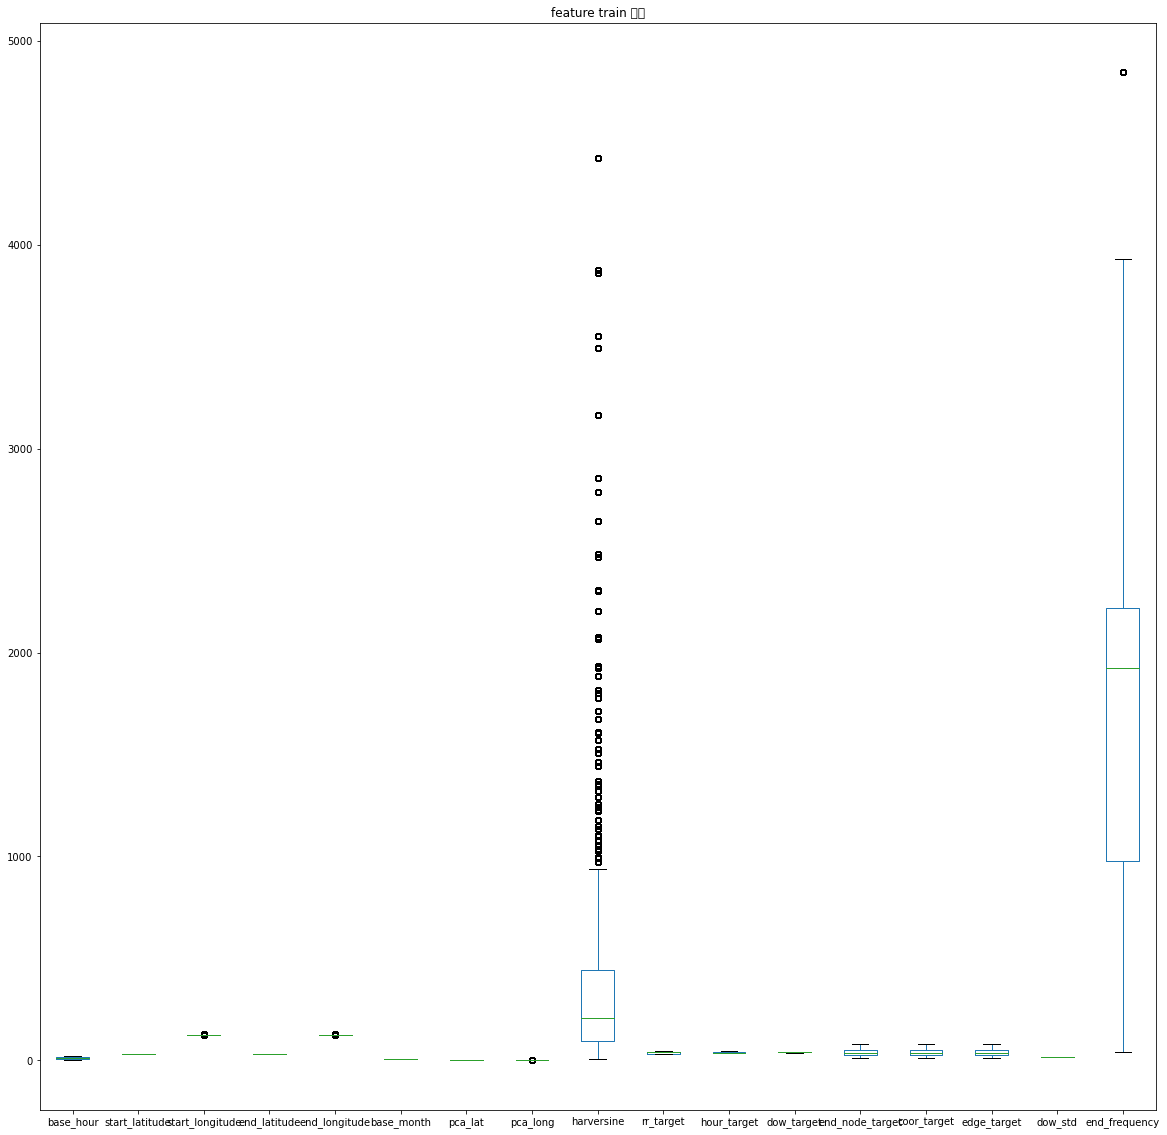

In [53]:
num = [i for i in feature_train.columns if i not in cat_encode+cat_uncode+['id','target']]

feature_train[num].plot.box(title="feature train 분포", figsize=(20,20))
plt.show()

In [52]:
# power, normalizer, robust 등 시도
scaler = PowerTransformer()
feature_train[num] = scaler.fit_transform(feature_train[num])
feature_test[num] = scaler.transform(feature_test[num])

NameError: name 'num' is not defined

In [56]:
date = str(pd.Timestamp.now())[:16].replace('-','').replace(' ','_').replace(':','')
feature_train.to_csv(f'/Users/hyunji/1. DaconJeju/data/train_{date}.csv', index=False)
feature_test.to_csv(f'/Users/hyunji/1. DaconJeju/data/test_{date}.csv', index=False)

### 4. Modeling

In [41]:
# 기준모델에 input하고 검증할 수 있도록 데이터를 나눈다.
del feature_train['id'], feature_test['id']

y_train = feature_train['target'] ; del feature_train['target']
X_train, X_test = feature_train, feature_test
print('X_train.shape:', X_train.shape, 'X_test.shape', X_test.shape)
print('feature:', X_train.columns)

X_train.shape: (524074, 23) X_test.shape (291241, 23)
feature: Index(['day_of_week', 'base_hour', 'maximum_speed_limit', 'road_type',
       'start_latitude', 'start_longitude', 'end_latitude', 'end_longitude',
       'end_turn_restricted', 'start_node_label', 'edge_label', 'base_month',
       'pca_lat', 'pca_long', 'harversine', 'rr_target', 'hour_target',
       'dow_target', 'end_node_target', 'coor_target', 'edge_target',
       'dow_std', 'end_frequency'],
      dtype='object')


In [42]:
train_X, val_X, train_y, val_y = train_test_split(X_train, y_train, test_size=0.2, shuffle=False, random_state=2022)

- #### LGBM

In [43]:
lgbm_reg = LGBMRegressor(n_estimators=2000, metric= 'mae', random_state = 2022)

In [46]:
fit_params={"early_stopping_rounds":1000, 
            "eval_metric" : 'mae', 
            "eval_set" : [(val_X, val_y)],
            'verbose': 1}

In [47]:
lgbm_reg.fit(train_X, train_y, **fit_params)

[1]	valid_0's l1: 11.7917
[2]	valid_0's l1: 10.7688
[3]	valid_0's l1: 9.861
[4]	valid_0's l1: 9.05585
[5]	valid_0's l1: 8.34709
[6]	valid_0's l1: 7.72169
[7]	valid_0's l1: 7.16909
[8]	valid_0's l1: 6.68649
[9]	valid_0's l1: 6.26818
[10]	valid_0's l1: 5.89421
[11]	valid_0's l1: 5.57443
[12]	valid_0's l1: 5.29553
[13]	valid_0's l1: 5.05521
[14]	valid_0's l1: 4.84457
[15]	valid_0's l1: 4.66695
[16]	valid_0's l1: 4.51356
[17]	valid_0's l1: 4.38449
[18]	valid_0's l1: 4.27186
[19]	valid_0's l1: 4.17737
[20]	valid_0's l1: 4.09548
[21]	valid_0's l1: 4.02474
[22]	valid_0's l1: 3.96438
[23]	valid_0's l1: 3.91021
[24]	valid_0's l1: 3.86476
[25]	valid_0's l1: 3.8247
[26]	valid_0's l1: 3.79077
[27]	valid_0's l1: 3.76162
[28]	valid_0's l1: 3.73677
[29]	valid_0's l1: 3.71482
[30]	valid_0's l1: 3.69298
[31]	valid_0's l1: 3.67639
[32]	valid_0's l1: 3.66092
[33]	valid_0's l1: 3.64717
[34]	valid_0's l1: 3.63174
[35]	valid_0's l1: 3.61879
[36]	valid_0's l1: 3.6083
[37]	valid_0's l1: 3.59649
[38]	valid_0's

[306]	valid_0's l1: 3.18974
[307]	valid_0's l1: 3.18793
[308]	valid_0's l1: 3.18704
[309]	valid_0's l1: 3.18685
[310]	valid_0's l1: 3.18588
[311]	valid_0's l1: 3.18449
[312]	valid_0's l1: 3.18382
[313]	valid_0's l1: 3.1832
[314]	valid_0's l1: 3.18291
[315]	valid_0's l1: 3.18228
[316]	valid_0's l1: 3.1815
[317]	valid_0's l1: 3.18132
[318]	valid_0's l1: 3.18055
[319]	valid_0's l1: 3.17904
[320]	valid_0's l1: 3.17781
[321]	valid_0's l1: 3.17686
[322]	valid_0's l1: 3.17536
[323]	valid_0's l1: 3.17439
[324]	valid_0's l1: 3.17359
[325]	valid_0's l1: 3.17316
[326]	valid_0's l1: 3.17224
[327]	valid_0's l1: 3.17107
[328]	valid_0's l1: 3.17016
[329]	valid_0's l1: 3.16886
[330]	valid_0's l1: 3.16853
[331]	valid_0's l1: 3.1685
[332]	valid_0's l1: 3.16798
[333]	valid_0's l1: 3.16764
[334]	valid_0's l1: 3.16693
[335]	valid_0's l1: 3.1657
[336]	valid_0's l1: 3.16435
[337]	valid_0's l1: 3.16356
[338]	valid_0's l1: 3.16288
[339]	valid_0's l1: 3.16227
[340]	valid_0's l1: 3.16209
[341]	valid_0's l1: 3.16

[616]	valid_0's l1: 3.04984
[617]	valid_0's l1: 3.04974
[618]	valid_0's l1: 3.04939
[619]	valid_0's l1: 3.049
[620]	valid_0's l1: 3.04888
[621]	valid_0's l1: 3.04868
[622]	valid_0's l1: 3.04856
[623]	valid_0's l1: 3.04826
[624]	valid_0's l1: 3.04736
[625]	valid_0's l1: 3.04718
[626]	valid_0's l1: 3.04708
[627]	valid_0's l1: 3.04701
[628]	valid_0's l1: 3.04662
[629]	valid_0's l1: 3.04657
[630]	valid_0's l1: 3.04584
[631]	valid_0's l1: 3.04539
[632]	valid_0's l1: 3.04527
[633]	valid_0's l1: 3.04506
[634]	valid_0's l1: 3.04478
[635]	valid_0's l1: 3.0446
[636]	valid_0's l1: 3.04442
[637]	valid_0's l1: 3.04424
[638]	valid_0's l1: 3.0441
[639]	valid_0's l1: 3.04402
[640]	valid_0's l1: 3.04391
[641]	valid_0's l1: 3.04388
[642]	valid_0's l1: 3.04359
[643]	valid_0's l1: 3.04325
[644]	valid_0's l1: 3.04289
[645]	valid_0's l1: 3.04271
[646]	valid_0's l1: 3.04237
[647]	valid_0's l1: 3.04212
[648]	valid_0's l1: 3.04148
[649]	valid_0's l1: 3.04125
[650]	valid_0's l1: 3.04111
[651]	valid_0's l1: 3.04

[938]	valid_0's l1: 2.98684
[939]	valid_0's l1: 2.98672
[940]	valid_0's l1: 2.98667
[941]	valid_0's l1: 2.98651
[942]	valid_0's l1: 2.98644
[943]	valid_0's l1: 2.98635
[944]	valid_0's l1: 2.98617
[945]	valid_0's l1: 2.98617
[946]	valid_0's l1: 2.98618
[947]	valid_0's l1: 2.9859
[948]	valid_0's l1: 2.98567
[949]	valid_0's l1: 2.9856
[950]	valid_0's l1: 2.98551
[951]	valid_0's l1: 2.98541
[952]	valid_0's l1: 2.98534
[953]	valid_0's l1: 2.98527
[954]	valid_0's l1: 2.98488
[955]	valid_0's l1: 2.98481
[956]	valid_0's l1: 2.98474
[957]	valid_0's l1: 2.98452
[958]	valid_0's l1: 2.98444
[959]	valid_0's l1: 2.98404
[960]	valid_0's l1: 2.98397
[961]	valid_0's l1: 2.98394
[962]	valid_0's l1: 2.98382
[963]	valid_0's l1: 2.98367
[964]	valid_0's l1: 2.98349
[965]	valid_0's l1: 2.98328
[966]	valid_0's l1: 2.98326
[967]	valid_0's l1: 2.98311
[968]	valid_0's l1: 2.98298
[969]	valid_0's l1: 2.98284
[970]	valid_0's l1: 2.98285
[971]	valid_0's l1: 2.98271
[972]	valid_0's l1: 2.98265
[973]	valid_0's l1: 2.

[1260]	valid_0's l1: 2.94975
[1261]	valid_0's l1: 2.94964
[1262]	valid_0's l1: 2.9496
[1263]	valid_0's l1: 2.94948
[1264]	valid_0's l1: 2.94942
[1265]	valid_0's l1: 2.94926
[1266]	valid_0's l1: 2.94897
[1267]	valid_0's l1: 2.94883
[1268]	valid_0's l1: 2.9488
[1269]	valid_0's l1: 2.94863
[1270]	valid_0's l1: 2.94828
[1271]	valid_0's l1: 2.94815
[1272]	valid_0's l1: 2.94805
[1273]	valid_0's l1: 2.94789
[1274]	valid_0's l1: 2.94777
[1275]	valid_0's l1: 2.94761
[1276]	valid_0's l1: 2.94728
[1277]	valid_0's l1: 2.9472
[1278]	valid_0's l1: 2.9472
[1279]	valid_0's l1: 2.94702
[1280]	valid_0's l1: 2.94672
[1281]	valid_0's l1: 2.94663
[1282]	valid_0's l1: 2.94652
[1283]	valid_0's l1: 2.94635
[1284]	valid_0's l1: 2.94632
[1285]	valid_0's l1: 2.94624
[1286]	valid_0's l1: 2.94607
[1287]	valid_0's l1: 2.94585
[1288]	valid_0's l1: 2.94566
[1289]	valid_0's l1: 2.94562
[1290]	valid_0's l1: 2.94551
[1291]	valid_0's l1: 2.94525
[1292]	valid_0's l1: 2.945
[1293]	valid_0's l1: 2.945
[1294]	valid_0's l1: 2

[1587]	valid_0's l1: 2.91913
[1588]	valid_0's l1: 2.91909
[1589]	valid_0's l1: 2.91906
[1590]	valid_0's l1: 2.91902
[1591]	valid_0's l1: 2.91892
[1592]	valid_0's l1: 2.91882
[1593]	valid_0's l1: 2.91877
[1594]	valid_0's l1: 2.91875
[1595]	valid_0's l1: 2.91869
[1596]	valid_0's l1: 2.91869
[1597]	valid_0's l1: 2.91852
[1598]	valid_0's l1: 2.91847
[1599]	valid_0's l1: 2.91841
[1600]	valid_0's l1: 2.91837
[1601]	valid_0's l1: 2.91836
[1602]	valid_0's l1: 2.91835
[1603]	valid_0's l1: 2.91828
[1604]	valid_0's l1: 2.91821
[1605]	valid_0's l1: 2.91818
[1606]	valid_0's l1: 2.9181
[1607]	valid_0's l1: 2.91806
[1608]	valid_0's l1: 2.91798
[1609]	valid_0's l1: 2.91787
[1610]	valid_0's l1: 2.91777
[1611]	valid_0's l1: 2.9177
[1612]	valid_0's l1: 2.91764
[1613]	valid_0's l1: 2.91754
[1614]	valid_0's l1: 2.91751
[1615]	valid_0's l1: 2.91732
[1616]	valid_0's l1: 2.91729
[1617]	valid_0's l1: 2.91715
[1618]	valid_0's l1: 2.91713
[1619]	valid_0's l1: 2.91711
[1620]	valid_0's l1: 2.9171
[1621]	valid_0's 

[1885]	valid_0's l1: 2.90076
[1886]	valid_0's l1: 2.90076
[1887]	valid_0's l1: 2.90075
[1888]	valid_0's l1: 2.90076
[1889]	valid_0's l1: 2.90057
[1890]	valid_0's l1: 2.90048
[1891]	valid_0's l1: 2.90045
[1892]	valid_0's l1: 2.90041
[1893]	valid_0's l1: 2.90027
[1894]	valid_0's l1: 2.90025
[1895]	valid_0's l1: 2.90023
[1896]	valid_0's l1: 2.90019
[1897]	valid_0's l1: 2.90012
[1898]	valid_0's l1: 2.90003
[1899]	valid_0's l1: 2.89996
[1900]	valid_0's l1: 2.89997
[1901]	valid_0's l1: 2.89986
[1902]	valid_0's l1: 2.89974
[1903]	valid_0's l1: 2.89966
[1904]	valid_0's l1: 2.89965
[1905]	valid_0's l1: 2.89955
[1906]	valid_0's l1: 2.89954
[1907]	valid_0's l1: 2.8995
[1908]	valid_0's l1: 2.89944
[1909]	valid_0's l1: 2.89922
[1910]	valid_0's l1: 2.89913
[1911]	valid_0's l1: 2.89907
[1912]	valid_0's l1: 2.89908
[1913]	valid_0's l1: 2.89904
[1914]	valid_0's l1: 2.89902
[1915]	valid_0's l1: 2.89901
[1916]	valid_0's l1: 2.89899
[1917]	valid_0's l1: 2.8988
[1918]	valid_0's l1: 2.89871
[1919]	valid_0's

LGBMRegressor(metric='mae', n_estimators=2000, random_state=2022)

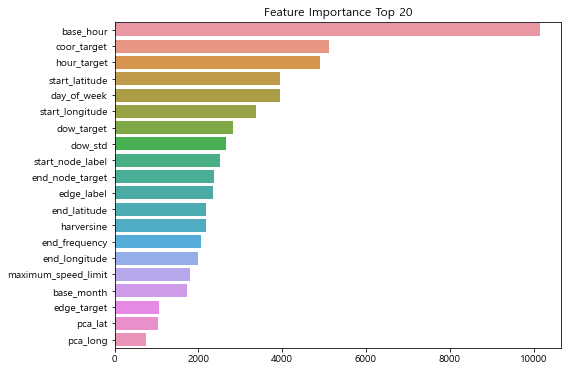

In [48]:
# LGBM의 Feature Importance
ft_importance_values = lgbm_reg.feature_importances_
ft_series = pd.Series(ft_importance_values, index = X_train.columns)
ft_top20 = ft_series.sort_values(ascending=False)[:20]

plt.figure(figsize=(8,6))
plt.title('Feature Importance Top 20')
sns.barplot(x=ft_top20, y=ft_top20.index)
plt.show()

- #### CatBoost
```python
cat_params = {'iterations':1000,
              'eval_metric':'MAE',
              'bootstrap_type':'Bayesian',
              'cat_features':['day_of_week', 'road_rating','connect_code', 'maximum_speed_limit',
                              'weight_restricted', 'road_type', 'start_turn_restricted', 'end_turn_restricted'],
              'random_state':2022, 'task_type':"GPU"}
cat_reg = CatBoostRegressor(**cat_params)
cat_reg.fit(train_X, train_y)
# Catboost의 Feature Importance
ft_importance_values = cat_reg.feature_importances_
ft_series = pd.Series(ft_importance_values, index = X_train.columns)
ft_top20 = ft_series.sort_values(ascending=False)[:20]
plt.figure(figsize=(8,6))
plt.title('Feature Importance Top 20')
sns.barplot(x=ft_top20, y=ft_top20.index)
plt.show()
```

### Submit

In [49]:
sample['target'] = lgbm_reg.predict(X_test)

# best와 비교!
oof = pd.read_csv('./data/submission/221108_oof.csv')
mean_absolute_error(sample['target'],oof['target'])

0.5310336384168621

In [ ]:
# 사용할 모델로 예측한 뒤 저장한다.
# sample['target'] = lgbm_reg.predict(X_test)
# date = str(pd.Timestamp.now())[:16].replace('-','').replace(' ','_').replace(':','')
# sample.to_csv(f'./data/submission/{date}.csv', index=False)